last updated: 2021-05-28


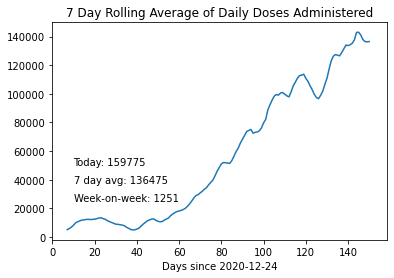

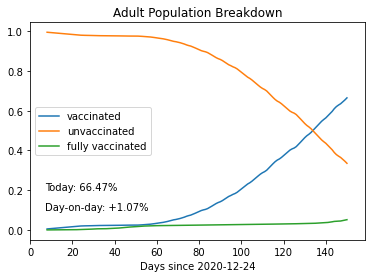

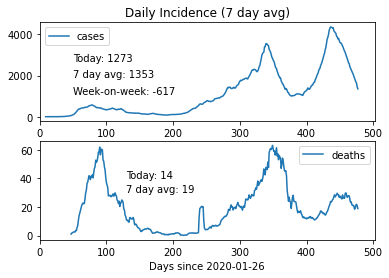

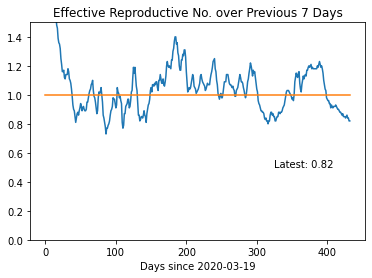

In [3]:
# -*- coding: utf-8 -*-
"""
Created on Sun May 16 12:29:12 2021

@author: hatto
"""

import urllib
import json
import numpy as np
import matplotlib.pyplot as plt
    
#constants

#from: https://www.fin.gov.on.ca/en/economy/demographics/projections/table6.html#year2019
pop = 12134923 #adult population only


#reading data

vacc_url = "https://data.ontario.ca/api/3/action/datastore_search?resource_id=8a89caa9-511c-4568-af89-7f2174b4378c&limit=1000"
case_url = "https://data.ontario.ca/api/3/action/datastore_search?resource_id=ed270bb8-340b-41f9-a7c6-e8ef587e6d11&limit=1000"
re_url = "https://data.ontario.ca/api/3/action/datastore_search?resource_id=1ffdf824-2712-4f64-b7fc-f8b2509f9204&limit=1000"  
vacc_file = urllib.request.urlopen(vacc_url)
case_file = urllib.request.urlopen(case_url)
re_file = urllib.request.urlopen(re_url)
vacc_response = json.loads(vacc_file.read())
case_response = json.loads(case_file.read())
re_response = json.loads(re_file.read())

doses=[]
dates=[]
total_doses=[]
full=[]
cases=[]
case_dates=[]
deaths=[]
re=[]
re_end_dates=[]

for day in vacc_response["result"]["records"]:
    doses += [day["previous_day_doses_administered"]]
    dates += [day["report_date"][:-9]]
    total_doses += [day["total_doses_administered"]]
    full += [day["total_individuals_fully_vaccinated"]]

for day in case_response["result"]["records"]:
    cases += [day["Total Cases"]]
    case_dates += [day["Reported Date"][:-9]]
    deaths += [day["Deaths"]]

for day in re_response["result"]["records"]:
    re += [day["Re"]]
    re_end_dates += [day["date_end"][:-9]]
    
#some light processing of data

xx=np.arange(0,len(total_doses)) #for the graph x axes
xx2=np.arange(0,len(cases))
xx3 = np.arange(0,len(re))

deaths = np.array(deaths) #convert to numpy array. Python lists are used for the accumulate
cases = np.array(cases)
total_doses=np.array(total_doses)
doses = np.array(doses)
deaths = np.array(deaths)
full = np.array(full)

doses = np.where(doses == None, np.nan, doses) #change the NoneType to nan so numpy will work
deaths = np.where(deaths == None, np.nan, deaths)
full = np.where(full == None, np.nan, full)
deaths = np.where(deaths == None, np.nan, deaths)
cases = np.where(cases == None, np.nan, cases)

#TODO: fix the nan values, padding, and subtraction to get the correct results

deaths = deaths[1:] - deaths[:-1] #Convert totals to daily amounts
cases = cases[1:] - cases[:-1]

doses_avg7 = np.convolve(doses, np.ones(7), 'valid') / 7 #take a weekly rolling average
deaths_avg7 = np.convolve(deaths, np.ones(7), 'valid') / 7
cases_avg7 = np.convolve(cases, np.ones(7), 'valid') / 7

temp = np.full((7), np.nan) #rolling avg removes 6 entries, add them back so lengths match
cases_avg7 = np.append(temp, cases_avg7)
deaths_avg7 = np.append(temp,deaths_avg7)
temp = np.full((6), np.nan)
doses_avg7 = np.append(temp,doses_avg7)

popvec = np.full(len(xx), pop) #vector filled with total pop
total_vacc = (total_doses - full)/pop #remove second doses
total_unvacc = (popvec/pop - total_vacc)
perc_vacc = total_vacc[-1]
full = full/pop

#plotting

fig2,ax2=plt.subplots()
ax2.set_title("7 Day Rolling Average of Daily Doses Administered")
ax2.set_xlabel("Days since "+dates[0])
ax2.plot(xx, doses_avg7)
ax2.set_xlim([0,1.05*len(xx)])
ax2.text(10,50000,"Today: {:n}".format(doses[-1]))
ax2.text(10,25000,"Week-on-week: {:n}".format(doses[-1] - doses[-8]))
ax2.text(10,37500,"7 day avg: {:n}".format(doses_avg7[-1]))

fig3,ax3=plt.subplots()
ax3.plot(xx, total_vacc)
ax3.plot(xx, total_unvacc)
ax3.plot(xx, full)
ax3.legend(["vaccinated", "unvaccinated", "fully vaccinated"])
ax3.set_title("Adult Population Breakdown")
ax3.set_xlabel("Days since " + dates[0])
ax3.set_xlim([0,1.05*len(xx)])
ax3.text(7,0.2,"Today: {:.2%}".format(perc_vacc))
ax3.text(7,0.1,"Day-on-day: +{:.2%}".format(total_vacc[-1] - total_vacc[-2]))

fig4,ax4=plt.subplots(2,1)
ax4[0].plot(xx2,cases_avg7)
ax4[0].set_title("Daily Incidence (7 day avg)")
ax4[0].set_xlabel("Days since "+case_dates[0])
ax4[0].legend(["cases"])
ax4[0].set_xlim([0,1.05*len(xx2)])
ax4[0].text(50, 2700, "Today: {:n}".format(cases[-1]))
ax4[0].text(50, 1100, "Week-on-week: {:.4n}".format(cases[-1] - cases[-8]))
ax4[0].text(50, 1900, "7 day avg: {:.4n}".format(cases_avg7[-1]))

ax4[1].plot(xx2,deaths_avg7)
ax4[1].legend(["deaths"])
ax4[1].set_xlim([0,1.05*len(xx2)])
ax4[1].set_xlabel("Days since "+case_dates[0])
ax4[1].text(130, 40, "Today: {:n}".format(deaths[-1]))
ax4[1].text(130, 30, "7 day avg: {:.2n}".format(deaths_avg7[-1]))

fig5,ax5=plt.subplots()
ax5.plot(xx3, re)
ax5.plot(xx3, np.full_like(xx3, 1))
ax5.set_title("Effective Reproductive No. over Previous 7 Days")
ax5.set_xlabel("Days since "+re_end_dates[0])
ax5.set_ylim([0,1.5])
ax5.text(325,0.5, "Latest: {:.2f}".format(re[-1]))

print("last updated: "+dates[-1])